In [1]:
!git clone https://github.com/YuanGongND/ast.git
!git clone https://github.com/NimayRKumar/in_the_jungle.git
!apt install python3.10-venv
!python3 -m venv venvast
!source venvast/bin/activate

Cloning into 'ast'...
remote: Enumerating objects: 649, done.
remote: Counting objects: 100% (146/146), done.
remote: Compressing objects: 100% (71/71), done.
remote: Total 649 (delta 85), reused 129 (delta 75), pack-reused 503
Receiving objects: 100% (649/649), 2.42 MiB | 19.98 MiB/s, done.
Resolving deltas: 100% (345/345), done.
Cloning into 'in_the_jungle'...
remote: Enumerating objects: 941, done.
remote: Counting objects: 100% (98/98), done.
remote: Compressing objects: 100% (63/63), done.
remote: Total 941 (delta 30), reused 84 (delta 19), pack-reused 843
Receiving objects: 100% (941/941), 103.85 MiB | 20.34 MiB/s, done.
Resolving deltas: 100% (40/40), done.
Updating files: 100% (891/891), done.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  python3-pip-whl python3-setuptools-whl
The following NEW packages will be installed:
  python3-pip-whl python3-setuptools-whl python3.10-

In [2]:
%cd ast

/content/ast


# The requirements.txt from the AST github have deprecated versions, use the following instead:
llvmlite

matplotlib==3.4.2

numba

numpy

scikit-learn

scipy

timm==0.4.5

torch

torchaudio

torchvision

wget

zipp

In [3]:
!pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 34.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.4/287.4 kB 30.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for matplotlib: filename=matplotlib-3.4.2-cp310-cp310-linux_x86_64.whl size=10436396 sha256=b0954aabf6c4c739f3ce758aee9aed8267c4a008e79f0f9bcc001f1690f97a84
  Stored in directory: /root/.cache/pip/wheels/d9/e8/73/f806fc40c211022378c2828e3cce1eac412344111ab1becd9d
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=7d58fee1d1433e460c7d7127572518a838b18e377e222e8f2b73292662a84929
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built matplotlib wget
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.7.1
    Uninstalling matplotlib-3.7.1:
      Successfully uninstalled matplotlib-3.7.1
ERROR: pip's dependen

In [4]:
%cd src
from models import ASTModel

/content/ast/src


In [5]:
%cd ../../in_the_jungle

/content/in_the_jungle


In [6]:
!pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.0/77.0 kB 2.5 MB/s eta 0:00:00


In [7]:
!echo -n "/content/in_the_jungle/data" > data_dir_path.txt
!ls

In [9]:
from preprocess import create_signal, pad_or_trim_audio, label_encoding
import numpy as np
import numpy as np
import torch.optim as optim
from torch.optim import lr_scheduler
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.models as models
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import librosa
import librosa.display
import os
import shutil
import json
from ast import literal_eval
from audiomentations import AddGaussianNoise, AirAbsorption, ApplyImpulseResponse, BandPassFilter, GainTransition, RepeatPart, TimeStretch, TanhDistortion
from sklearn.model_selection import train_test_split
import time
import copy

def get_spectrogram(signal, sr=22050):
  spectrogram = librosa.feature.melspectrogram(y=signal, sr=sr)
  return librosa.amplitude_to_db(spectrogram)

def get_mfcc(signal, n_mfcc=13):
    return librosa.feature.mfcc(y=signal, n_mfcc=n_mfcc)


In [11]:
with open("./data_dir_path.txt") as f:
    data_dir = f.read()

print(data_dir)

df = pd.DataFrame(columns=["signal", "label"])
subdirs = [f for f in os.listdir(data_dir) if not f.startswith('.')]

for sd in subdirs:
    out_path = "{}/{}".format(data_dir, sd)
    for file in os.listdir("{}/wav".format(out_path)):
        sig = create_signal("{}/wav/{}".format(out_path, file), out_path)
        sig = pad_or_trim_audio(sig, 22050 * 2)
        df.loc[len(df)] = [sig, label_encoding[sd]]


signal = np.vstack(df["signal"])
label = np.array(df["label"])

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
x_train, x_test, y_train, y_test = train_test_split(signal, label, test_size=0.2)
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

spectrogram_train = get_spectrogram(x_train, sr=16000)
spectrogram_test = get_spectrogram(x_test, sr=16000)
print(spectrogram_train.shape)

mfcc_train = get_mfcc(x_train, n_mfcc=20)
mfcc_test = get_mfcc(x_test, n_mfcc=20)
print(mfcc_train.shape)

/content/in_the_jungle/data
(700, 44100) (700,) (175, 44100) (175,)
(700, 128, 87)
(700, 20, 87)


In [23]:
train_data_spectrogram = []
test_data_spectrogram = []

train_data_mfcc = []
test_data_mfcc = []

for i in range(spectrogram_train.shape[0]):
    train_data_spectrogram.append((spectrogram_train[i], y_train[i]))
    train_data_mfcc.append((mfcc_train[i], y_train[i]))

for i in range(spectrogram_test.shape[0]):
    test_data_spectrogram.append((spectrogram_test[i], y_test[i]))
    test_data_mfcc.append((mfcc_test[i], y_test[i]))


train_loader_spectrogram = torch.utils.data.DataLoader(train_data_spectrogram, batch_size=32)
train_loader_mfcc = torch.utils.data.DataLoader(train_data_mfcc, batch_size=32)

test_loader_spectrogram = torch.utils.data.DataLoader(test_data_spectrogram, batch_size=32)
test_loader_mfcc = torch.utils.data.DataLoader(test_data_mfcc, batch_size=32)

In [13]:
def train(net, optimizer, criterion, train_loader, test_loader, epochs):
    model = net.to(device)
    total_step = len(train_loader)
    overall_step = 0
    train_loss_values = []
    train_error = []
    val_loss_values = []
    val_error = []
    for epoch in range(epochs):
        print("epoch", epoch)
        correct = 0
        total = 0
        flag = 0
        running_loss = 0.0
        for i, (images, labels) in enumerate(train_loader):
            # Move tensors to configured device
            images = images.to(device)
            labels = labels.to(device)
            #Forward Pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            optimizer.step()
            # if (i+1) % 1000 == 0:
            #   print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, epochs, i+1, total_step, loss.item()))
            # if plot:
            #   info = { ('loss_' + model_name): loss.item() }

              #for tag, value in info.items():
                #logger.scalar_summary(tag, value, overall_step+1)
        train_loss_values.append(running_loss)
        train_error.append(100-100*correct/total)

        model.eval()
        with torch.no_grad():
            correct = 0
            total = 0
            for i, (images, labels) in enumerate(test_loader):
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        print('Accuracy of the network on the test images: {} %'.format(100 * correct / total))
        val_error.append(100-100*correct/total)
        val_loss_values.append(running_loss)
    return val_error,val_loss_values,train_error,train_loss_values

In [20]:
%cd /content/ast/src/models

/content/ast/src/models


In [21]:
ast_mdl = ASTModel(label_dim=10, input_tdim=128, input_fdim=87, audioset_pretrain=True, imagenet_pretrain=True)

---------------AST Model Summary---------------
ImageNet pretraining: True, AudioSet pretraining: True
frequncey stride=10, time stride=10
number of patches=96


In [25]:
model = ast_mdl.to(device)
epochs = 50
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=10e-5, nesterov=True)
val_error,val_loss_values,train_error,train_loss_values= train(model, optimizer, criterion, train_loader_spectrogram, test_loader_spectrogram, epochs)

epoch 0
Accuracy of the network on the test images: 64.0 %
epoch 1
Accuracy of the network on the test images: 65.14285714285714 %
epoch 2
Accuracy of the network on the test images: 61.714285714285715 %
epoch 3
Accuracy of the network on the test images: 72.57142857142857 %
epoch 4
Accuracy of the network on the test images: 69.71428571428571 %
epoch 5
Accuracy of the network on the test images: 77.71428571428571 %
epoch 6
Accuracy of the network on the test images: 70.28571428571429 %
epoch 7
Accuracy of the network on the test images: 74.28571428571429 %
epoch 8
Accuracy of the network on the test images: 73.71428571428571 %
epoch 9
Accuracy of the network on the test images: 76.0 %
epoch 10
Accuracy of the network on the test images: 75.42857142857143 %
epoch 11
Accuracy of the network on the test images: 72.57142857142857 %
epoch 12
Accuracy of the network on the test images: 70.28571428571429 %
epoch 13
Accuracy of the network on the test images: 77.71428571428571 %
epoch 14
Accu

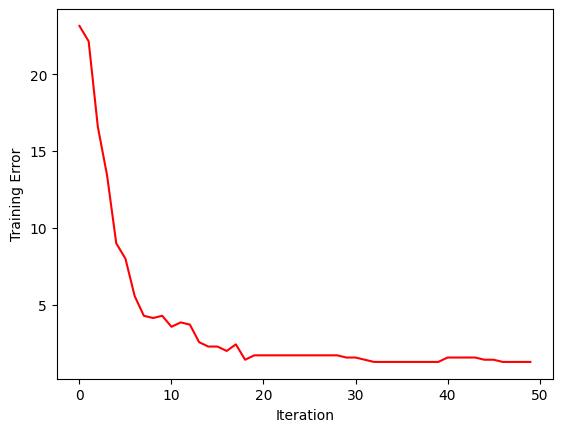

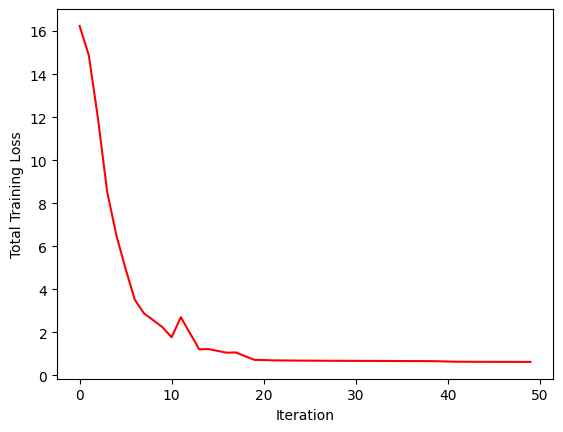

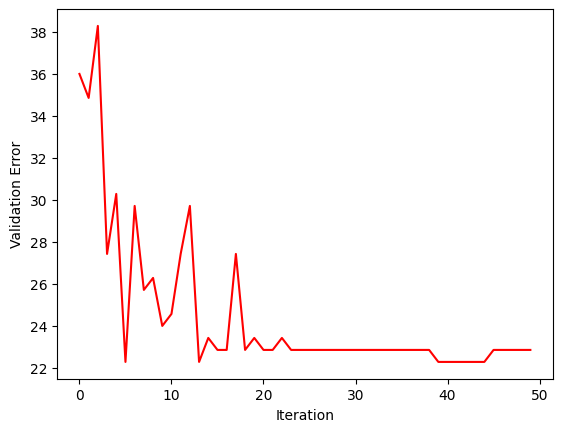

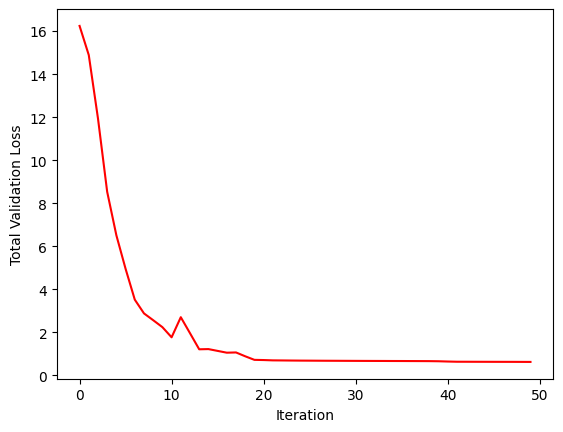

In [27]:
plt.plot(train_error, 'r')
plt.xlabel('Iteration')
plt.ylabel('Training Error')
plt.show()

plt.plot(train_loss_values, 'r')
plt.xlabel('Iteration')
plt.ylabel('Total Training Loss')
plt.show()

plt.plot(val_error, 'r')
plt.xlabel('Iteration')
plt.ylabel('Validation Error')
plt.show()

plt.plot(val_loss_values, 'r')
plt.xlabel('Iteration')
plt.ylabel('Total Validation Loss')
plt.show()

In [28]:
ast_mdl2 = ASTModel(label_dim=10, input_tdim=20, input_fdim=87, audioset_pretrain=True, imagenet_pretrain=True)
model2 = ast_mdl2.to(device)
epochs = 50
criterion2 = nn.CrossEntropyLoss()

optimizer2 = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=10e-5, nesterov=True)
val_error2,val_loss_values2,train_error2,train_loss_values2= train(model2, optimizer2, criterion2, train_loader_mfcc, test_loader_mfcc, epochs)

---------------AST Model Summary---------------
ImageNet pretraining: True, AudioSet pretraining: True
frequncey stride=10, time stride=10
number of patches=8
epoch 0
Accuracy of the network on the test images: 8.0 %
epoch 1
Accuracy of the network on the test images: 8.0 %
epoch 2
Accuracy of the network on the test images: 8.0 %
epoch 3
Accuracy of the network on the test images: 8.0 %
epoch 4
Accuracy of the network on the test images: 8.0 %
epoch 5
Accuracy of the network on the test images: 8.0 %
epoch 6
Accuracy of the network on the test images: 8.0 %
epoch 7
Accuracy of the network on the test images: 8.0 %
epoch 8
Accuracy of the network on the test images: 8.0 %
epoch 9
Accuracy of the network on the test images: 8.0 %
epoch 10
Accuracy of the network on the test images: 8.0 %
epoch 11
Accuracy of the network on the test images: 8.0 %
epoch 12
Accuracy of the network on the test images: 8.0 %
epoch 13
Accuracy of the network on the test images: 8.0 %
epoch 14
Accuracy of the 